Attribute Information:
1. MPG: continues
2. Cylinder: multi-valued discrete
3. Displacement: continues
4. Horsepower: continues
5. Weight: continues
6. Acceleration:  continues
7. Model Year: multi-valued discrete
8. Origin: multi-values discrete
9. Car Name: string (unique for each instance)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2026-02-09 12:37:29.633891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-09 12:37:29.633921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-09 12:37:29.634983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-09 12:37:29.641452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 12:37:30.540153: W tensorflow/compiler/tf2

2.15.1


In [3]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin"]

raw_dataset = pd.read_csv(url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# Cleaning the data

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# Drop those rows to keep things simple
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [8]:
# Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
# For One Features
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)

In [9]:
# Use only numeric columns for normalization
numeric_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']
normalizer.adapt(np.array(train_features[numeric_features]))
horsepower_normalizer.adapt(np.array(train_features['Horsepower']).reshape(-1, 1))

2026-02-09 12:37:41.267581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-09 12:37:41.311186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-09 12:37:41.311502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
def linModel(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.1))
    return model

In [11]:
def noLinModel(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.1))
    return model

In [12]:
linOneFeatureModel = linModel(horsepower_normalizer)
linAllFeatureModel = linModel(normalizer)

In [13]:
noLinOneFeatureModel = noLinModel(horsepower_normalizer)
noLinAllFeatureModel = noLinModel(normalizer)

In [14]:
linOneFeatureModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [15]:
%%time
# Linear regression with one feature
history = linOneFeatureModel.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2, # Use 20% of the training data for validation
    verbose=0,
    epochs=100
)

2026-02-09 12:37:48.760612: I external/local_xla/xla/service/service.cc:168] XLA service 0x7034fcb496b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-09 12:37:48.760655: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2026-02-09 12:37:48.766987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-09 12:37:48.783564: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1770658668.857028 2119194 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 5.54 s, sys: 413 ms, total: 5.95 s
Wall time: 4.51 s


In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802938,4.197817,95
96,3.803757,4.184861,96
97,3.803500,4.191019,97
98,3.802408,4.191471,98
99,3.806589,4.190405,99


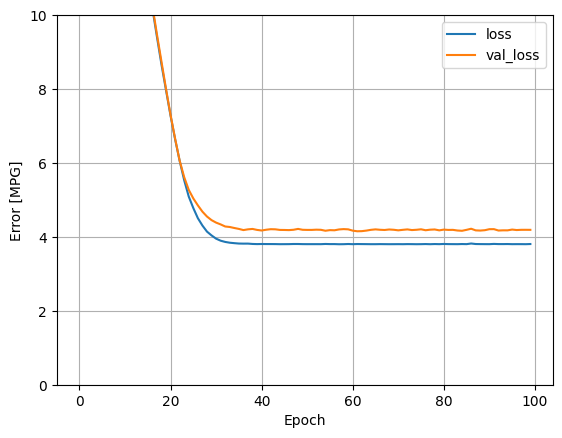

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [18]:
%%time
# Linear Regression with all features
history = linAllFeatureModel.fit(
    train_features[numeric_features],
    train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=0
)

CPU times: user 5.07 s, sys: 402 ms, total: 5.47 s
Wall time: 3.97 s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.621989,2.692460,95
96,2.625854,2.643171,96
97,2.616760,2.710181,97
98,2.609590,2.674801,98
99,2.615859,2.670966,99


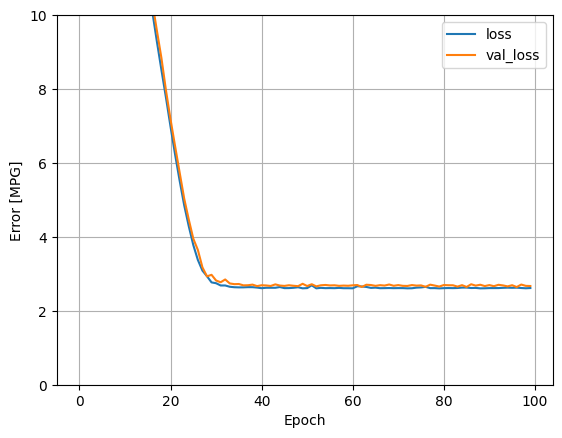

In [20]:
plot_loss(history)

In [21]:
test_results = {}

test_results['horsepower_model'] = linOneFeatureModel.evaluate(test_features['Horsepower'], 
                                                               test_labels, verbose=0)

In [22]:
x = tf.linspace(0.0, 250, 251)
y = linOneFeatureModel.predict(x)

8/8 [==============================] - 0s 1ms/step


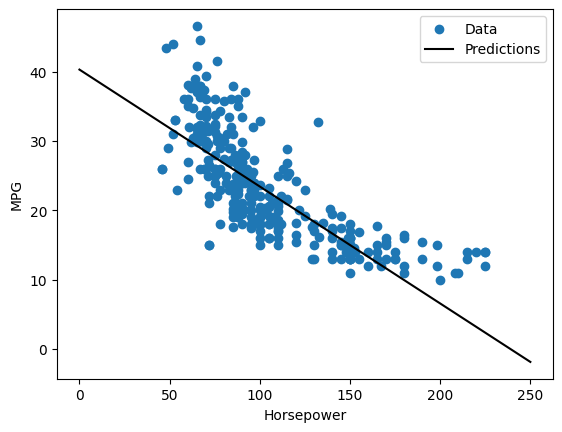

In [23]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

plot_horsepower(x, y)

In [24]:
%%time

# Non Linear Regression One Feature
history = noLinOneFeatureModel.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2, # Use 20% of the training data for validation
    verbose=0,
    epochs=100
)

CPU times: user 6.11 s, sys: 383 ms, total: 6.49 s
Wall time: 5.08 s


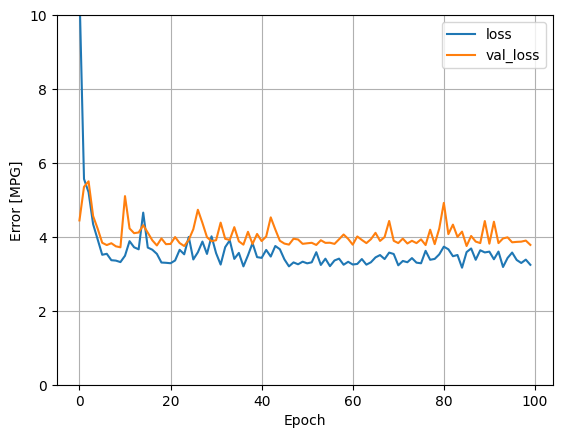

In [25]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.575917,3.853108,95
96,3.374899,3.864779,96
97,3.293864,3.870893,97
98,3.384651,3.899970,98
99,3.244071,3.782895,99


In [29]:
x = tf.linspace(0.0, 250, 251)
y = noLinOneFeatureModel.predict(x)

8/8 [==============================] - 0s 1ms/step


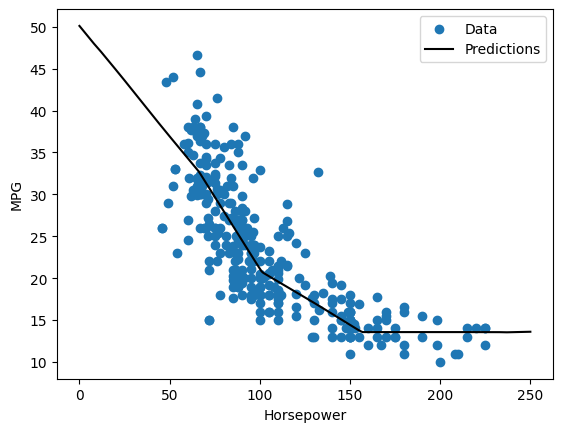

In [30]:
plot_horsepower(x, y)

In [31]:
%%time
# Non Linear Regression with all features
history = noLinAllFeatureModel.fit(
    train_features[numeric_features],
    train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=0
)

CPU times: user 6.13 s, sys: 446 ms, total: 6.58 s
Wall time: 5.07 s


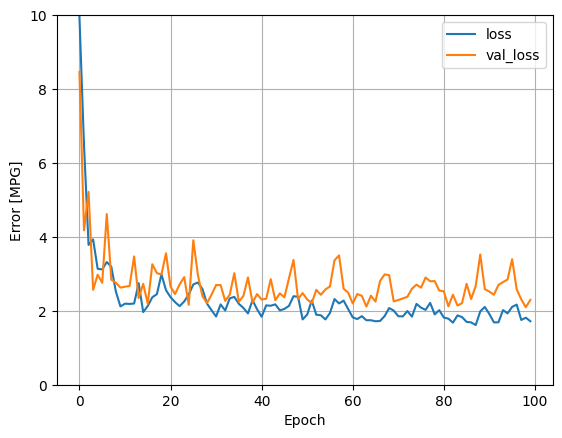

In [32]:
plot_loss(history)

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.106057,3.396222,95
96,2.168108,2.582273,96
97,1.752295,2.310300,97
98,1.813920,2.097310,98
99,1.717764,2.294074,99


In [34]:
# Evaluate all models on the test set
test_results = {}

In [35]:
test_results['linOne'] = linOneFeatureModel.evaluate(test_features['Horsepower'], test_labels, verbose=0)
test_results['linAll'] = linAllFeatureModel.evaluate(test_features[numeric_features], test_labels, verbose=0)
test_results['noLinOne'] = noLinOneFeatureModel.evaluate(test_features['Horsepower'], test_labels, verbose=0)
test_results['noLinAll'] = noLinAllFeatureModel.evaluate(test_features[numeric_features], test_labels, verbose=0)

In [36]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linOne,3.635412
linAll,2.474164
noLinOne,2.744114
noLinAll,1.874712


3/3 [==============================] - 0s 2ms/step


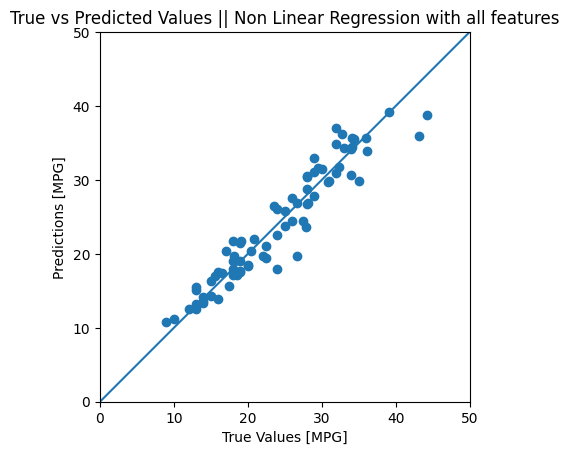

In [38]:
# Make predictions with the best model
test_predictions = noLinAllFeatureModel.predict(test_features[numeric_features]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.title('True vs Predicted Values || Non Linear Regression with all features')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

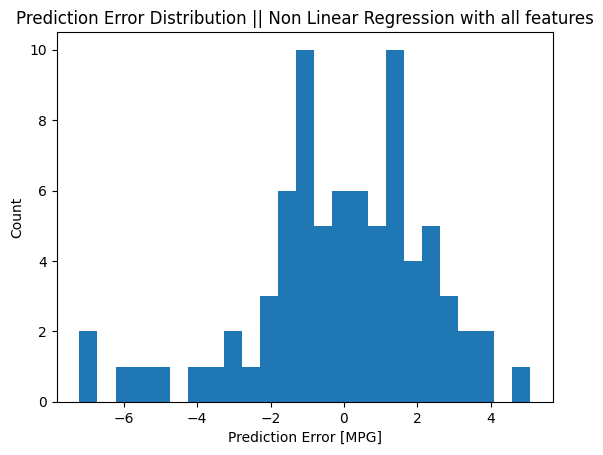

In [39]:
# Error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.title('Prediction Error Distribution || Non Linear Regression with all features')
_ = plt.ylabel("Count")

In [41]:
# Save Load Model

noLinAllFeatureModel.save('noLinAllFeatureModel')
reloaded = tf.keras.models.load_model('noLinAllFeatureModel')

test_results['reloaded'] = reloaded.evaluate(test_features[numeric_features], test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

INFO:tensorflow:Assets written to: noLinAllFeatureModel/assets


INFO:tensorflow:Assets written to: noLinAllFeatureModel/assets


,Mean absolute error [MPG]
linOne,3.635412
linAll,2.474164
noLinOne,2.744114
noLinAll,1.874712
reloaded,1.874712
